In [13]:
import numpy as np
import pandas as pd

from conf_eval import metrics, plot
import seaborn as sns

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score
from nonconformist_DL.icp import IcpClassifierDl

from nonconformist_DL.nc import NcFactory, ClassifierNcDl, MarginErrFunc

# Set the figure size to re-use so it fits the screen OK
fig_size = (14,7)

# Set a different style and context
plot.update_plot_settings(context='talk', font_scale=1.2)

In [14]:
df_val = pd.read_csv('/home/jovyan/my_code/uncertainty/data/hERGDB/hERGDB_cls_valid_data.csv')
df_week1 = pd.read_csv('/home/jovyan/my_code/uncertainty/data/hERGDB/hERGDB_cls_week1_1201.csv')
df_week2 = pd.read_csv('/home/jovyan/my_code/uncertainty/data/hERGDB/hERGDB_cls_week2_1201.csv')
df_week3 = pd.read_csv('/home/jovyan/my_code/uncertainty/data/hERGDB/hERGDB_cls_week3_1201.csv')
df_week4 = pd.read_csv('/home/jovyan/my_code/uncertainty/data/hERGDB/hERGDB_cls_week4_1201.csv')

y_week1_smi = np.array(df_week1['smiles'])
y_week1_clf = np.array(df_week1['class'])

y_week2_smi = np.array(df_week2['smiles'])
y_week2_clf = np.array(df_week2['class'])

y_week3_smi = np.array(df_week3['smiles'])
y_week3_clf = np.array(df_week3['class'])

y_week4_smi = np.array(df_week4['smiles'])
y_week4_clf = np.array(df_week4['class'])

y_calib_smi = np.array(df_val['smiles'])
y_calib_clf = np.array(df_val['class'])

In [15]:
import chemprop

def chemprop_pred(smiles_list):
    arguments = [
        '--test_path', '/dev/null',
        '--preds_path', '/dev/null',
        '--checkpoint_dir', '/home/jovyan/my_code/uncertainty/checkpoints/hERGDB/hERGDB_model'
    ]

    args = chemprop.args.PredictArgs().parse_args(arguments)
    model_objects = chemprop.train.load_model(args=args)
    smiles = [[s]for s in smiles_list]

    preds = chemprop.train.make_predictions(
        args=args, 
        smiles=smiles, 
        model_objects=model_objects,
        return_invalid_smiles=True
        )
    
    preds = np.array([[1-p[0], p[0]] for p in preds])
    return preds

week1_preds = chemprop_pred(y_week1_smi)
week2_preds = chemprop_pred(y_week2_smi)
week3_preds = chemprop_pred(y_week3_smi)
week4_preds = chemprop_pred(y_week4_smi)

Loading training args


/home/jovyan/miniconda3/envs/py39/lib/python3.9/site-packages/chemprop/utils.py:473: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vars(torch.load(path, map_location=lambda 

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 843


100%|██████████| 1/1 [00:03<00:00,  3.33s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:03
Loading training args
Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 646


100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:03
Loading training args
Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1,052


100%|██████████| 1/1 [00:03<00:00,  3.76s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
Loading training args
Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 775


100%|██████████| 1/1 [00:02<00:00,  2.65s/it]

Saving predictions to /dev/null
Elapsed time = 0:00:03


In [4]:
# df_train = pd.read_csv('/home/jovyan/my_code/uncertainty/data/hERGDB/hERGDB_cls_train_data.csv')
# df_test = pd.read_csv('/home/jovyan/my_code/uncertainty/data/hERGDB/hERGDB_cls_week1_1201.csv')
# df_val = pd.read_csv('/home/jovyan/my_code/uncertainty/data/hERGDB/hERGDB_cls_valid_data.csv')

# y_train_clf = np.array(df_train['class'])
# y_test_clf = np.array(df_test['class'])
# y_calib_clf = np.array(df_val['class'])

In [6]:
icp = IcpClassifierDl(condition=lambda x: x[1]) 
icp.calibrate(y_true = np.array(y_calib_clf.copy()), y_pred = week1_preds.copy())

In [59]:
week1_predictions = icp.predict_conf(week1_preds.copy())
cp_week1_pred=  week1_predictions[:, 0]
print(
    'week1',
    'acc', "{:.3f}".format(accuracy_score(y_week1_clf, cp_week1_pred)), 
    'auc', "{:.3f}".format(roc_auc_score(y_week1_clf, cp_week1_pred)), 
    'precision', "{:.3f}".format(precision_score(y_week1_clf, cp_week1_pred)), 
    'recall', "{:.3f}".format(recall_score(y_week1_clf, cp_week1_pred))
    )


week2_predictions = icp.predict_conf(week2_preds.copy())
cp_week2_pred=  week2_predictions[:, 0]
print(
    'week2',
    'acc', "{:.3f}".format(accuracy_score(y_week2_clf, cp_week2_pred)), 
    'auc', "{:.3f}".format(roc_auc_score(y_week2_clf, cp_week2_pred)), 
    'precision', "{:.3f}".format(precision_score(y_week2_clf, cp_week2_pred)), 
    'recall', "{:.3f}".format(recall_score(y_week2_clf, cp_week2_pred))
    )


week3_predictions = icp.predict_conf(week3_preds.copy())
cp_week3_pred=  week3_predictions[:, 0]
print(
    'week2',
    'acc', "{:.3f}".format(accuracy_score(y_week3_clf, cp_week3_pred)), 
    'auc', "{:.3f}".format(roc_auc_score(y_week3_clf, cp_week3_pred)), 
    'precision', "{:.3f}".format(precision_score(y_week3_clf, cp_week3_pred)), 
    'recall', "{:.3f}".format(recall_score(y_week3_clf, cp_week3_pred))
    )


week4_predictions = icp.predict_conf(week4_preds.copy())
cp_week4_pred=  week4_predictions[:, 0]
print(
    'week2',
    'acc', "{:.3f}".format(accuracy_score(y_week4_clf, cp_week4_pred)), 
    'auc', "{:.3f}".format(roc_auc_score(y_week4_clf, cp_week4_pred)), 
    'precision', "{:.3f}".format(precision_score(y_week4_clf, cp_week4_pred)), 
    'recall', "{:.3f}".format(recall_score(y_week4_clf, cp_week4_pred))
    )


week1 acc 0.689 auc 0.684 precision 0.581 recall 0.660
week2 acc 0.628 auc 0.617 precision 0.636 recall 0.744
week2 acc 0.720 auc 0.716 precision 0.698 recall 0.810
week2 acc 0.737 auc 0.734 precision 0.796 recall 0.748


In [107]:
predictions = icp.predict(week4_preds.copy())

Confusion matrix using significance ε=0.1



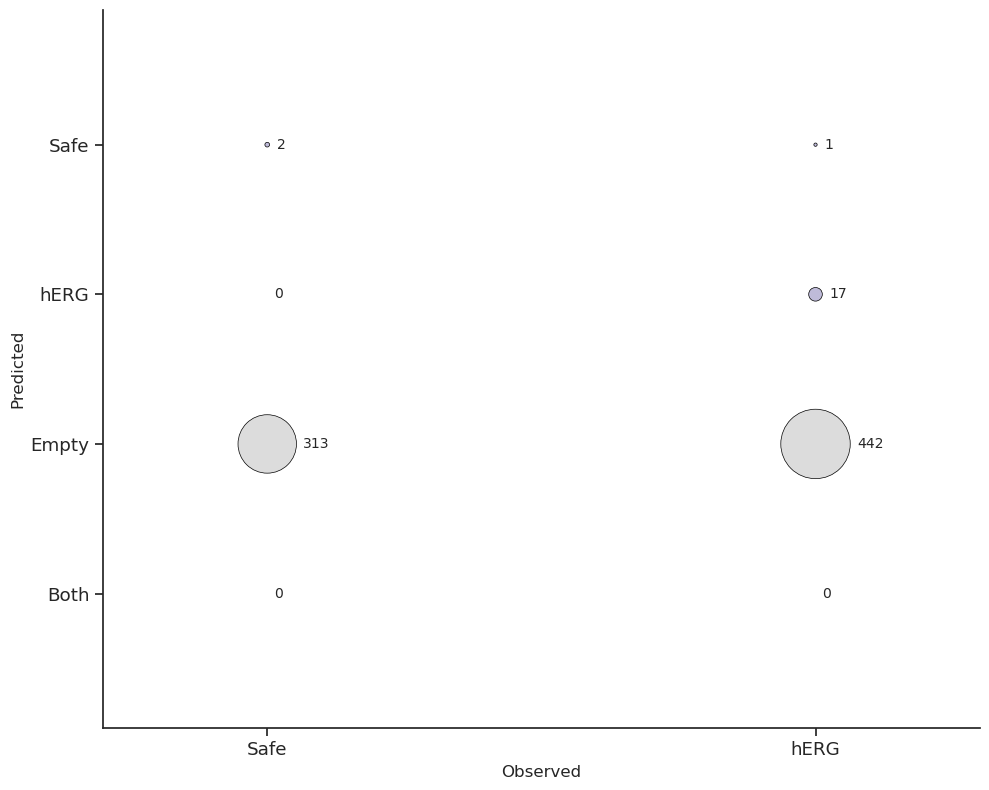

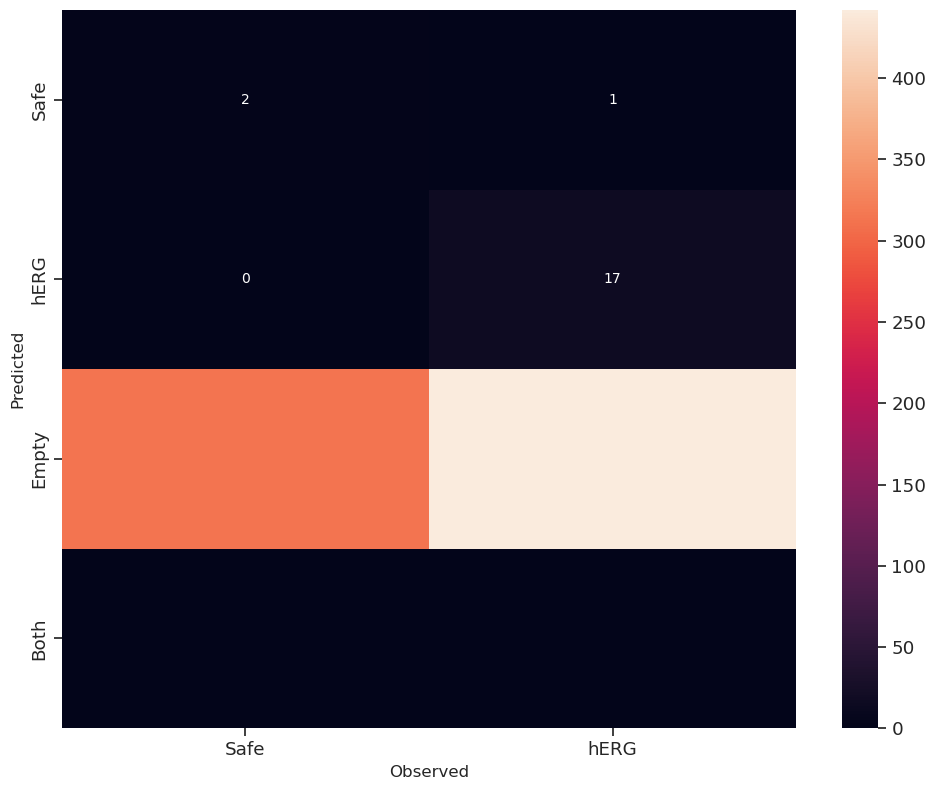

In [108]:
CM = metrics.confusion_matrix(y_week4_clf, predictions, sign=0.9, labels=['Safe','hERG'])
print('Confusion matrix using significance \u03B5=0.1\n')

# Plot the confusion matrix with bubbles - requries seaborn!
CM_plot = plot.plot_confusion_matrix_bubbles(CM,
                                                annotate=True) # If numbers should be printed next to bubbles

heatmap_fig = plot.plot_confusion_matrix_heatmap(CM)

In [101]:
def process_preds(predictions, y_true):
    out_predictions = []
    out_y_true = []
    for i, y in zip(predictions, y_true):
        if i[0] == i[1]:
            pass
        else:
            out_predictions.append(np.where(i==True)[0][0])
            out_y_true.append(y)
    return np.array(out_predictions), np.array(out_y_true)

def cal_sig_auc(preds, y_true):
    output = {
        'num_samples': [],
        'auc':[],
        'sig': []
    }
    for sig in np.linspace(0, 1, 20):
        try:
            predictions = icp.predict(preds.copy(), significance=sig)
            predictions, out_y_true = process_preds(predictions, y_true)
            auc = roc_auc_score(out_y_true, predictions)
            output['num_samples'].append(len(out_y_true))
            output['auc'].append(auc)
            output['sig'].append(sig)
        except:
            pass
    return output

output_week1 = cal_sig_auc(week1_preds, y_week1_clf)
output_week2 = cal_sig_auc(week2_preds, y_week2_clf)
output_week3 = cal_sig_auc(week3_preds, y_week3_clf)
output_week4 = cal_sig_auc(week4_preds, y_week4_clf)

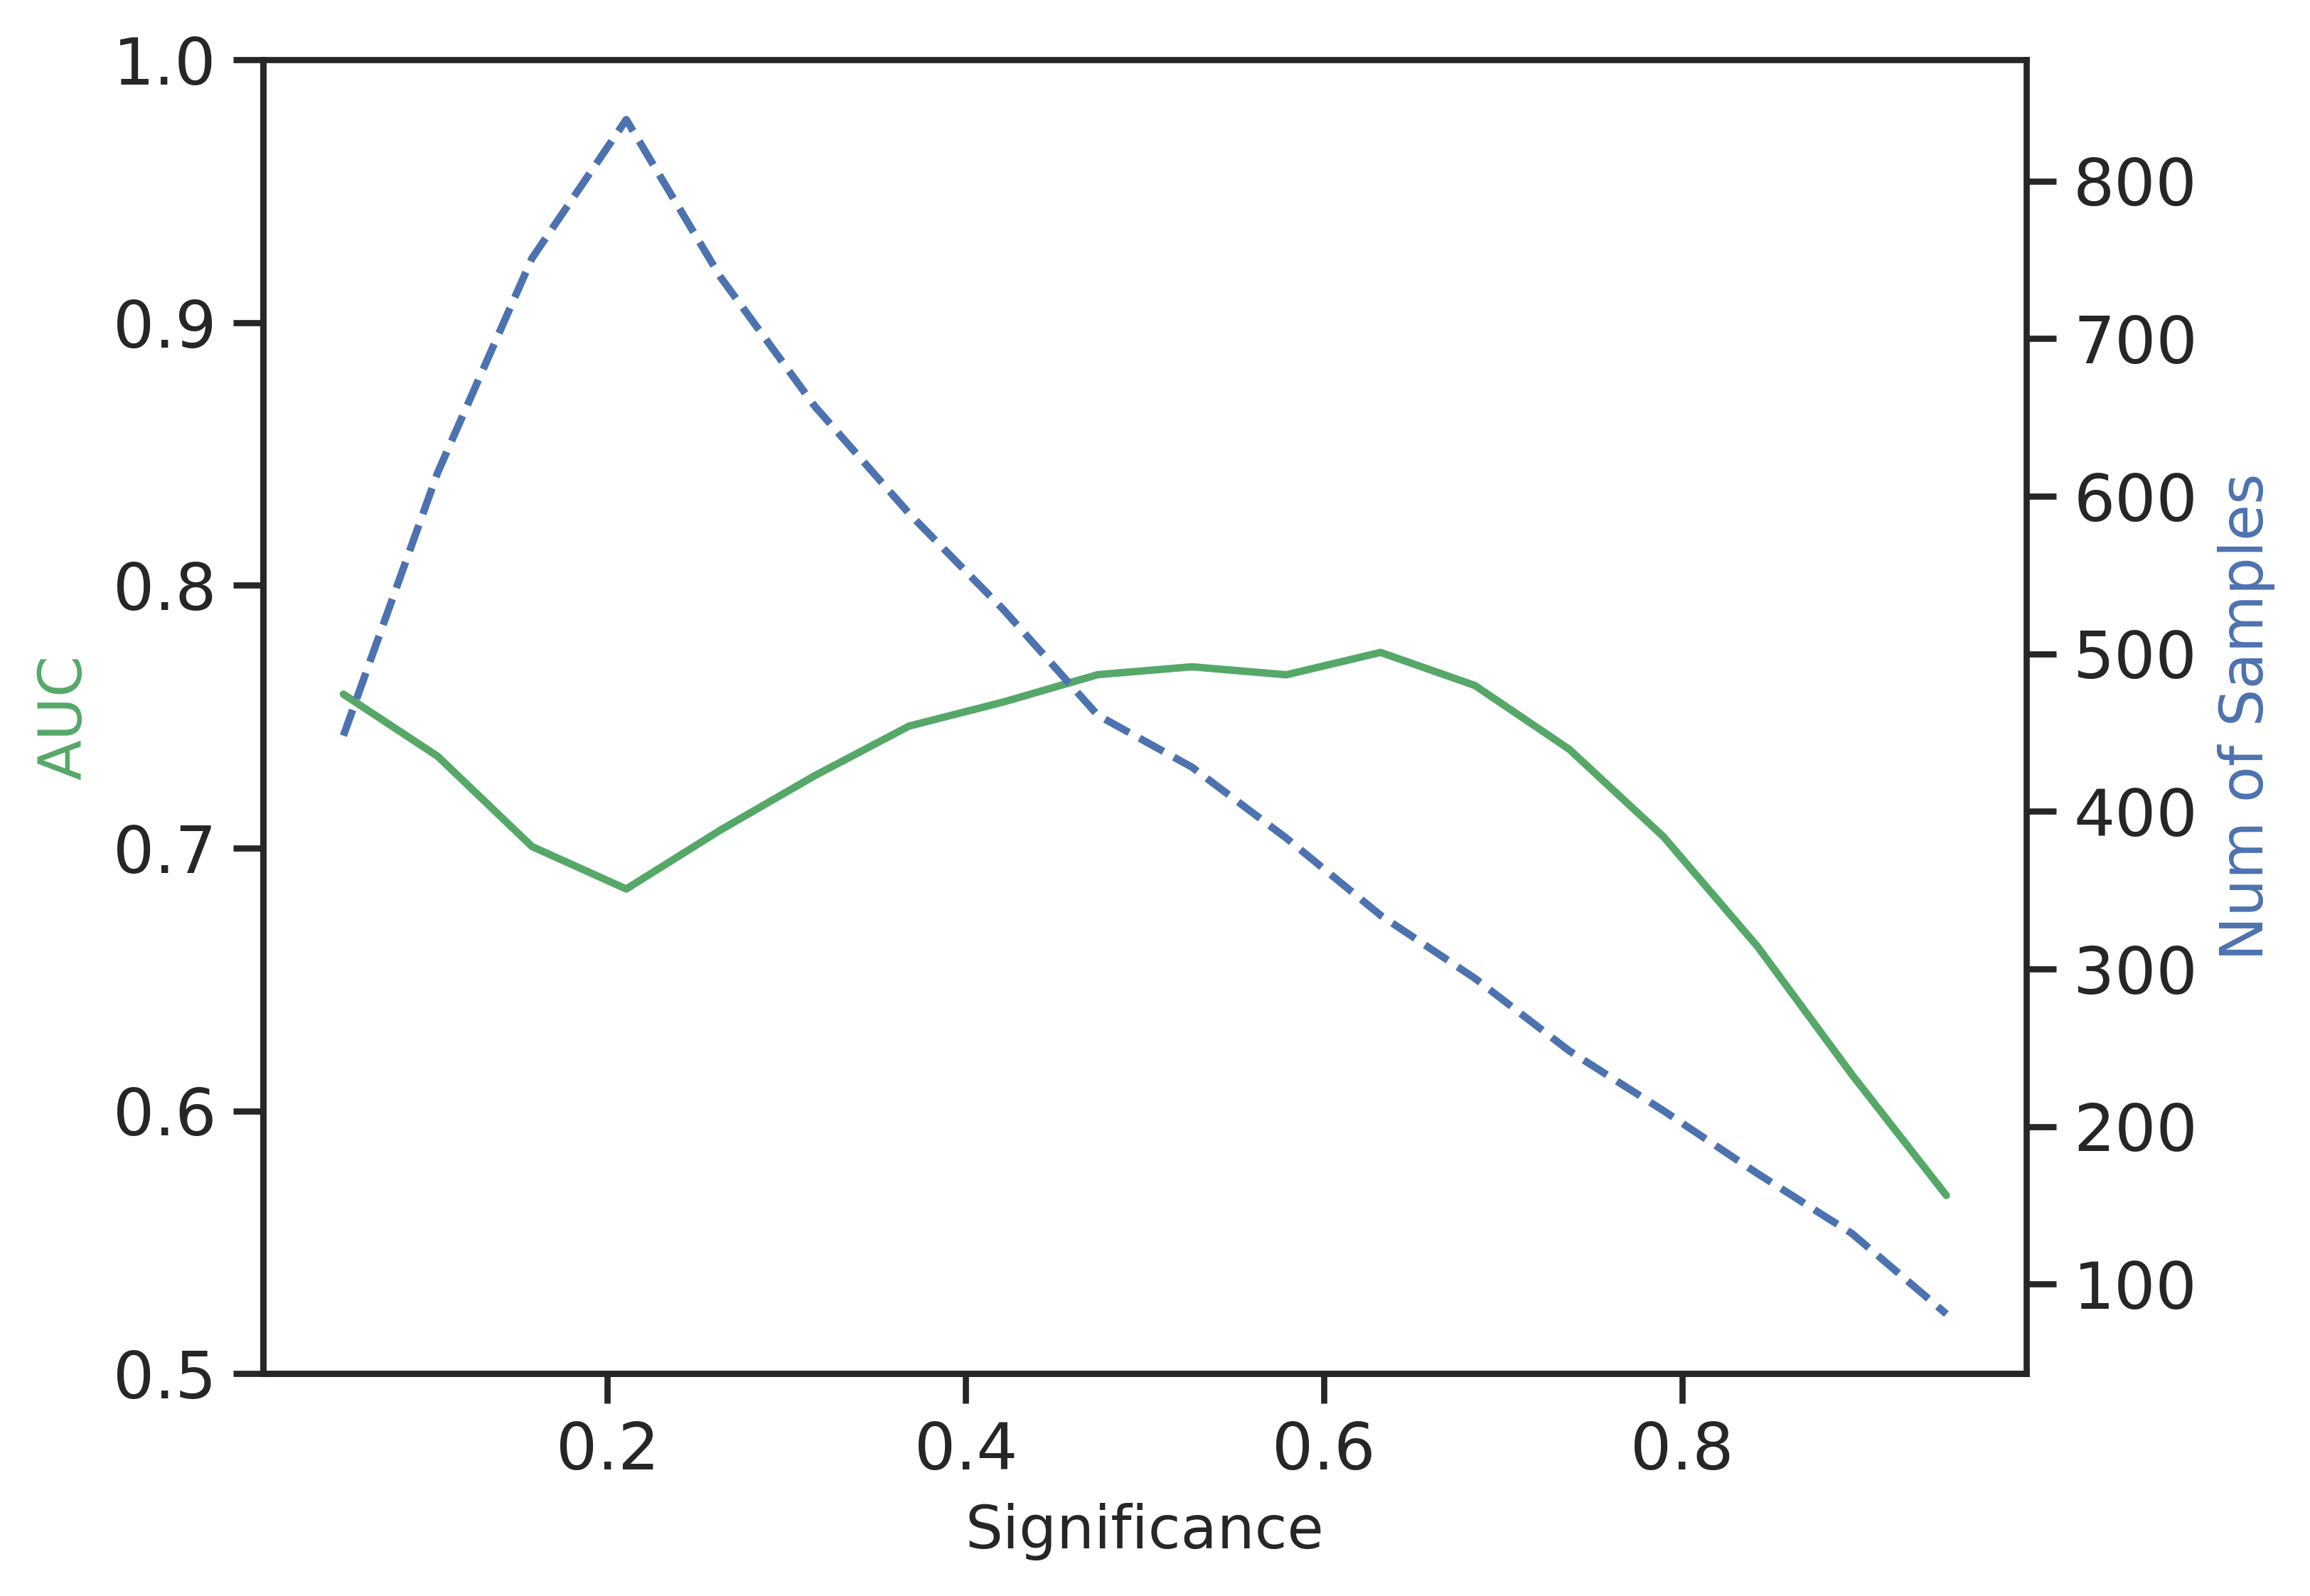

In [114]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn-v0_8-deep')
 
x = output_week1['sig']
y1= output_week1['auc']
y2= output_week1['num_samples']
 
fig, ax1 = plt.subplots(dpi=500)
ax2 = ax1.twinx()           # 做镜像处理
ax1.plot(x,y1,'g-')
ax2.plot(x,y2,'b--')
 
ax1.set_xlabel('Significance')    #设置x轴标题
ax1.set_ylabel('AUC',color = 'g')   #设置Y1轴标题
ax2.set_ylabel('Num of Samples', color = 'b')   #设置Y2轴标题
ax1.set_ylim(0.5, 1)


ax1.spines['top'].set_visible(True)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['right'].set_visible(True)

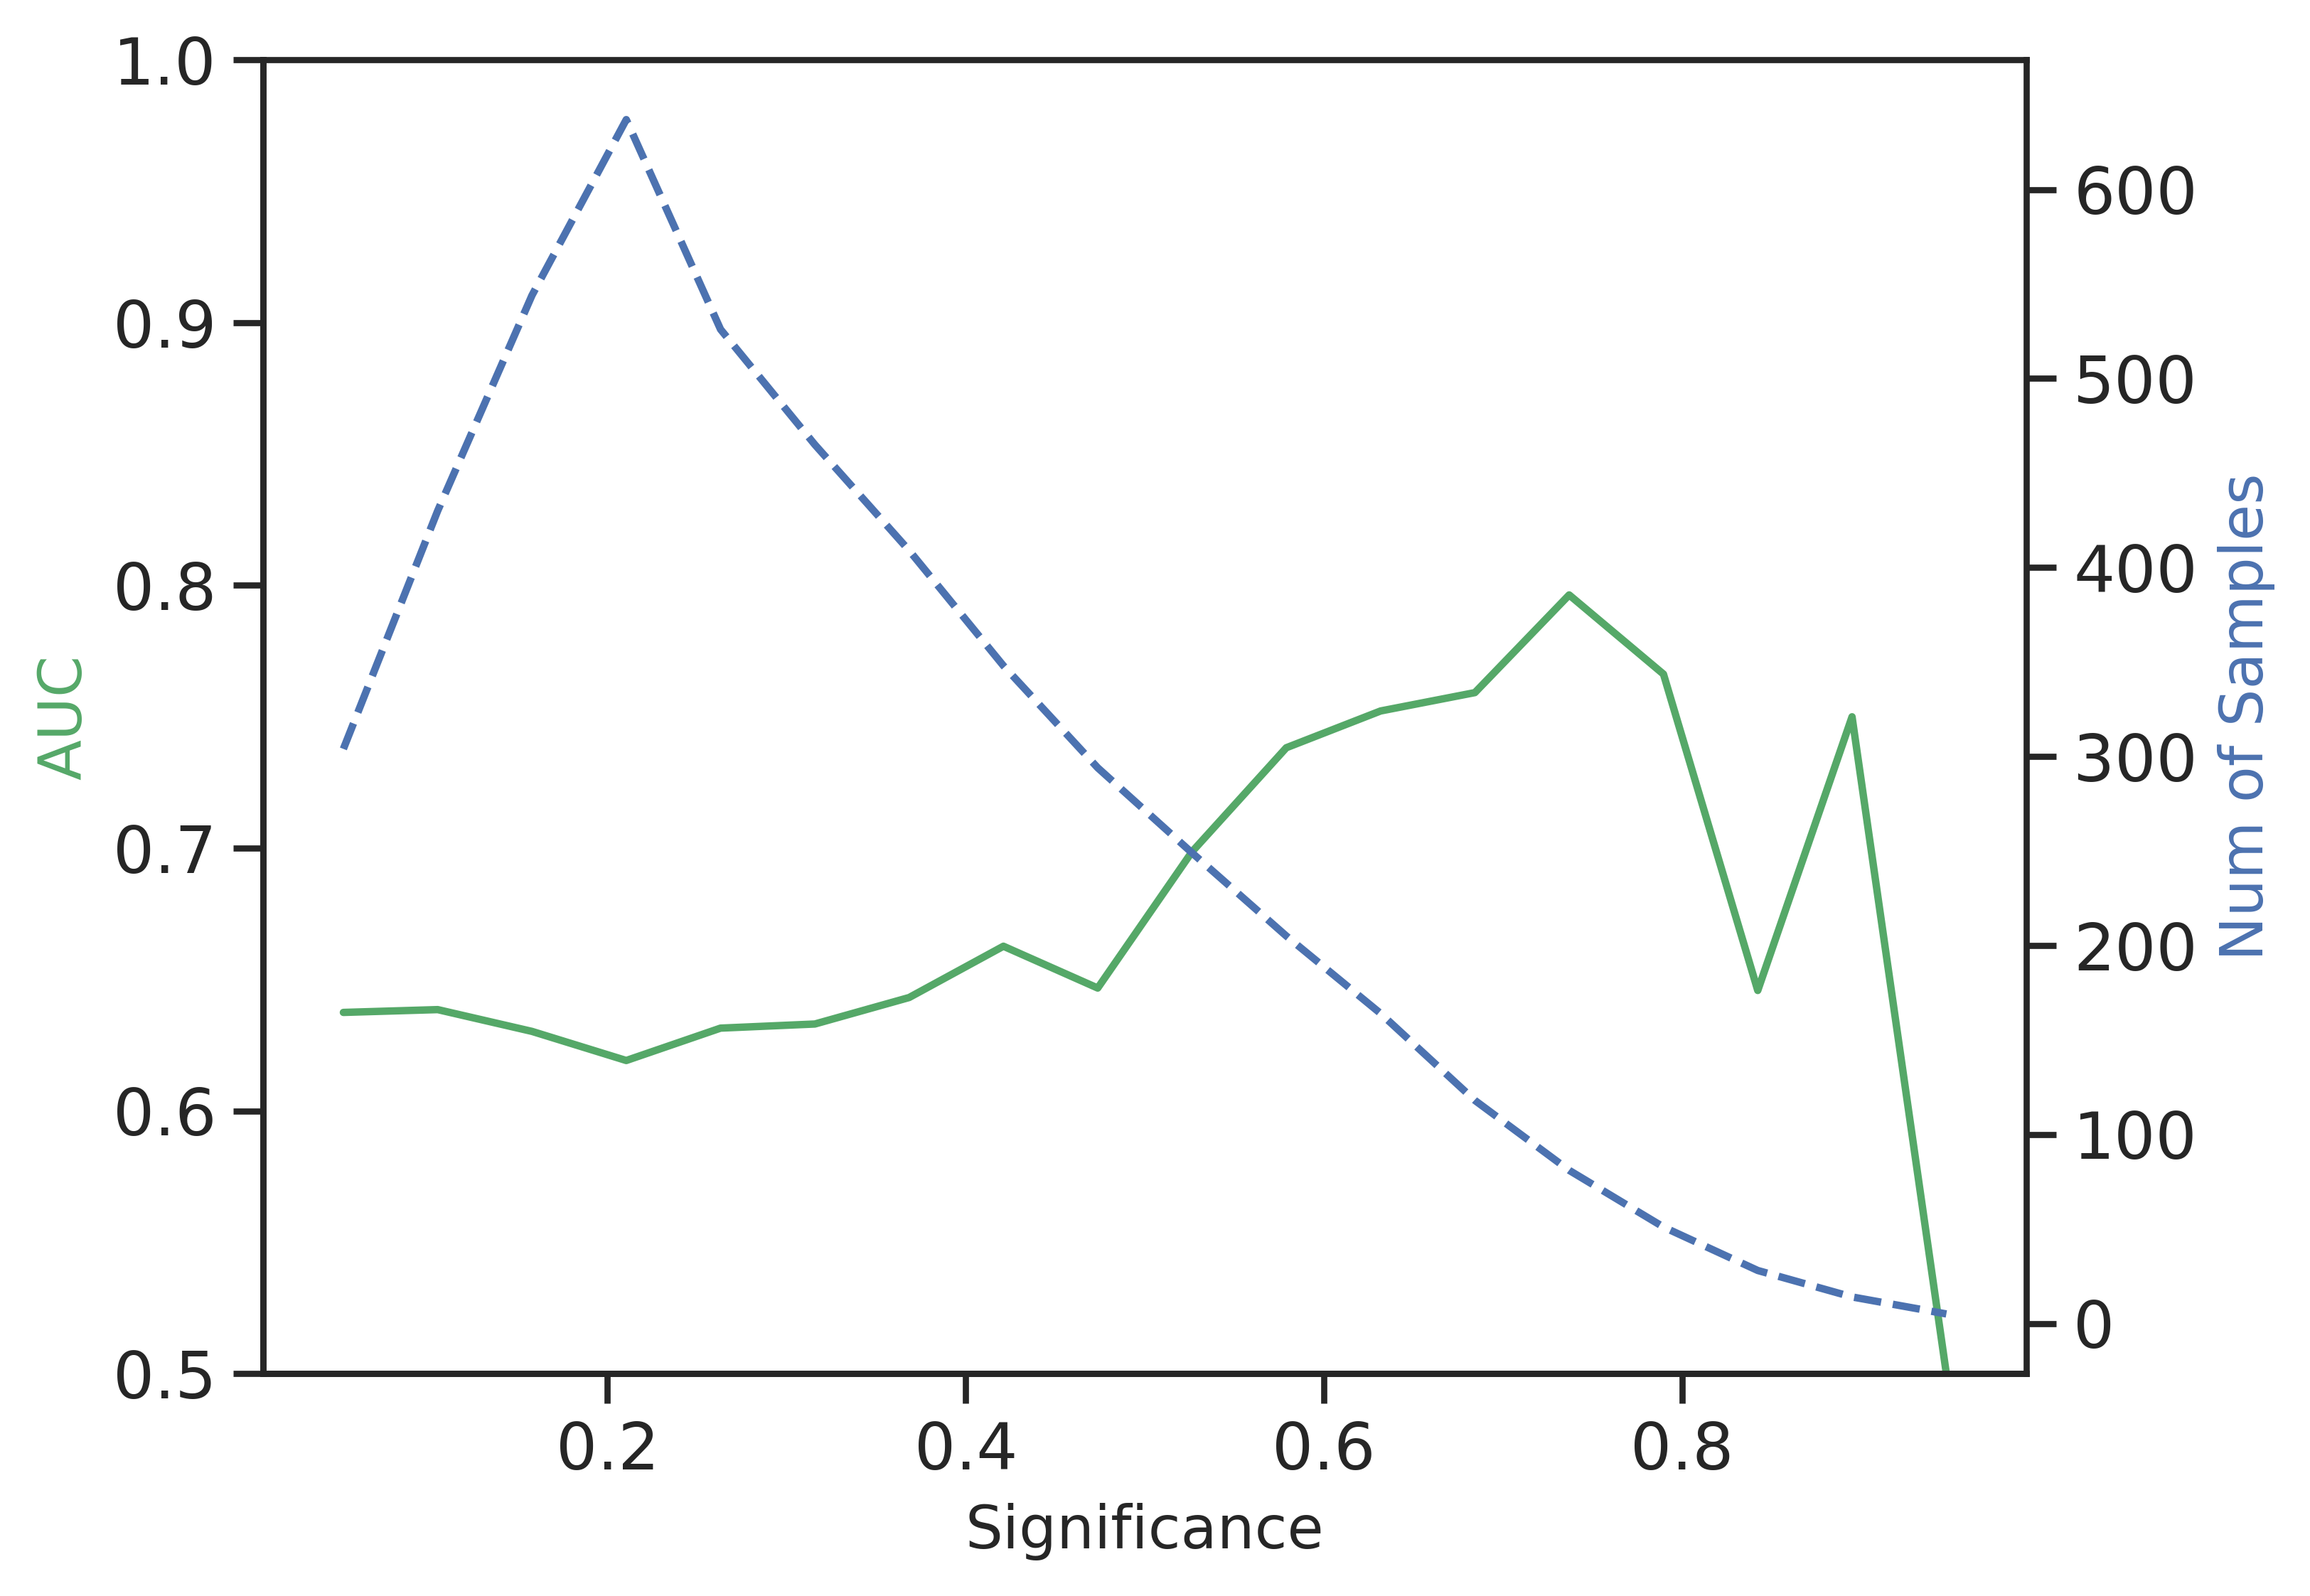

In [115]:
x = output_week2['sig']
y1= output_week2['auc']
y2= output_week2['num_samples']
 
fig, ax1 = plt.subplots(dpi=500)
ax2 = ax1.twinx()           # 做镜像处理
ax1.plot(x,y1,'g-')
ax2.plot(x,y2,'b--')
 
ax1.set_xlabel('Significance')    #设置x轴标题
ax1.set_ylabel('AUC',color = 'g')   #设置Y1轴标题
ax2.set_ylabel('Num of Samples', color = 'b')   #设置Y2轴标题
ax1.set_ylim(0.5, 1)

ax1.spines['top'].set_visible(True)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['right'].set_visible(True)

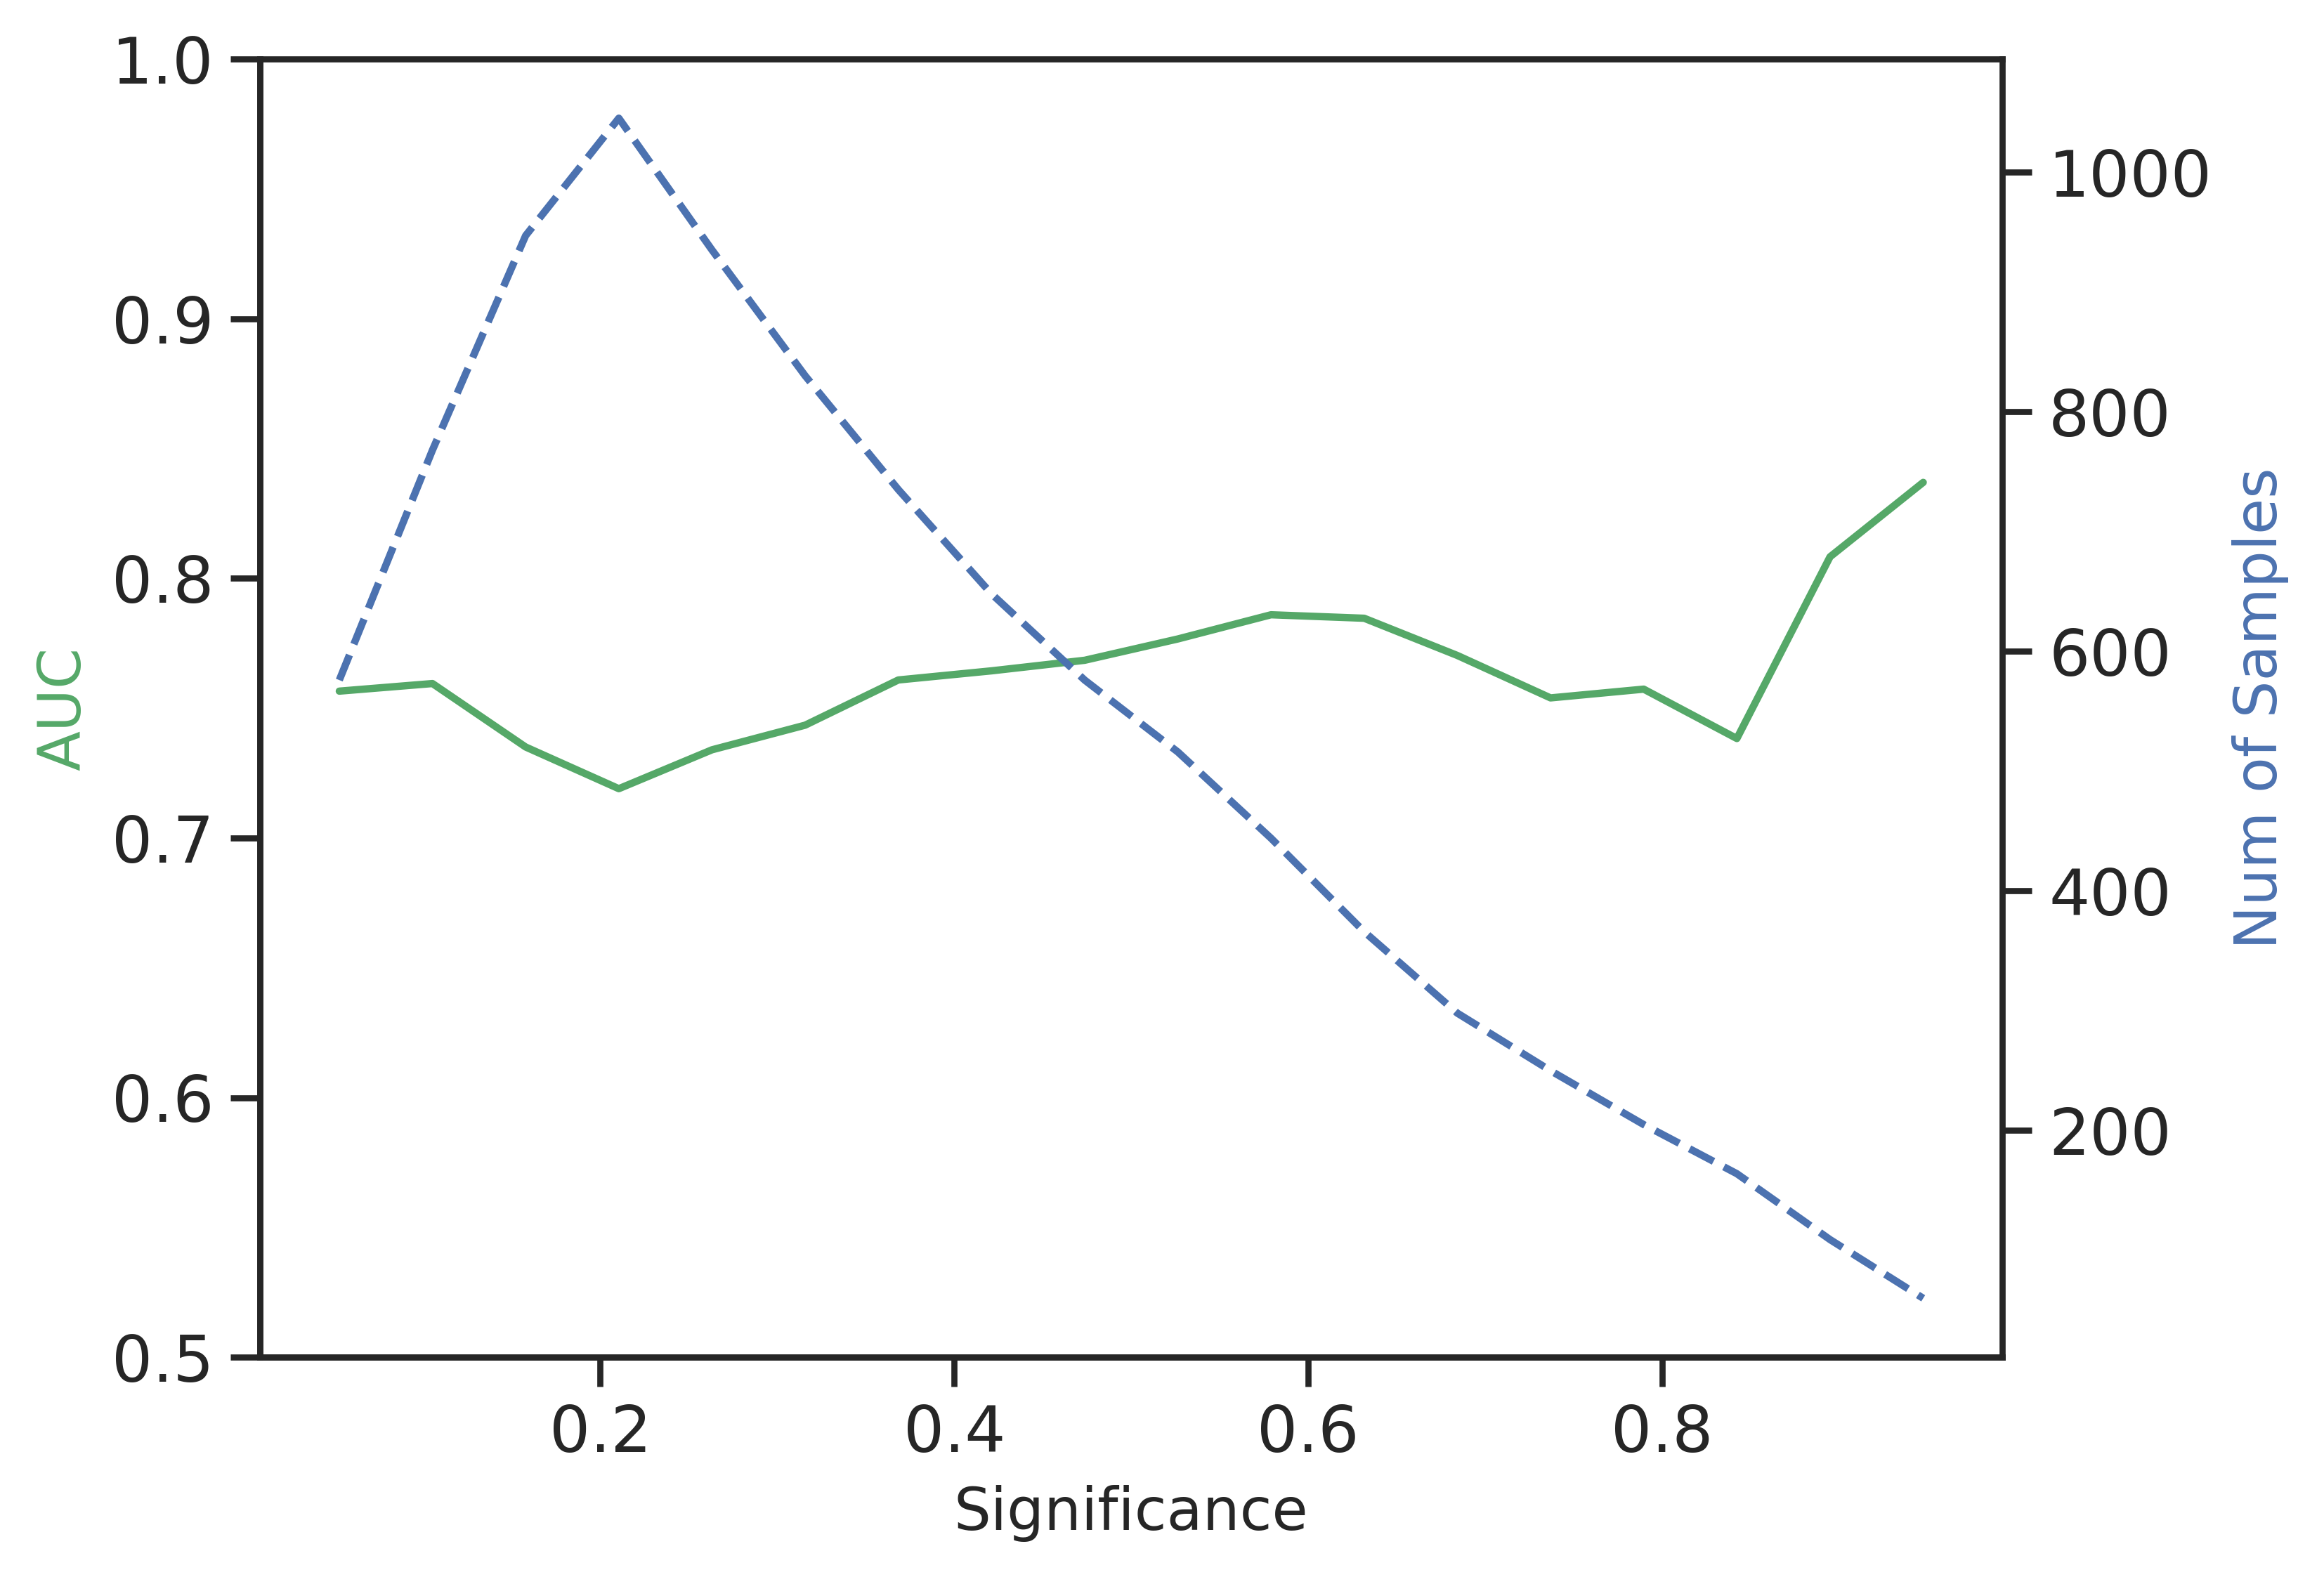

In [111]:
x = output_week3['sig']
y1= output_week3['auc']
y2= output_week3['num_samples']
 
fig, ax1 = plt.subplots(dpi=500)
ax2 = ax1.twinx()           # 做镜像处理
ax1.plot(x,y1,'g-')
ax2.plot(x,y2,'b--')
 
ax1.set_xlabel('Significance')    #设置x轴标题
ax1.set_ylabel('AUC',color = 'g')   #设置Y1轴标题
ax2.set_ylabel('Num of Samples', color = 'b')   #设置Y2轴标题
ax1.set_ylim(0.5, 1)

ax1.spines['top'].set_visible(True)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['right'].set_visible(True)

In [106]:
output_week3

{'num_samples': [576,
  768,
  947,
  1045,
  935,
  830,
  735,
  648,
  576,
  516,
  444,
  366,
  298,
  250,
  205,
  164,
  109,
  60],
 'auc': [0.7565919415366383,
  0.7595139765862317,
  0.7350726581712497,
  0.7190186456591263,
  0.7339944966750745,
  0.7434824721094151,
  0.7608914885034288,
  0.7644095549990368,
  0.7684763914470073,
  0.7766859932865425,
  0.786008230452675,
  0.7846638655462186,
  0.7703293237824931,
  0.7539850201651622,
  0.7573585626911314,
  0.7383373205741627,
  0.8083333333333333,
  0.8369963369963368],
 'sig': [0.05263157894736842,
  0.10526315789473684,
  0.15789473684210525,
  0.21052631578947367,
  0.2631578947368421,
  0.3157894736842105,
  0.3684210526315789,
  0.42105263157894735,
  0.47368421052631576,
  0.5263157894736842,
  0.5789473684210527,
  0.631578947368421,
  0.6842105263157894,
  0.7368421052631579,
  0.7894736842105263,
  0.8421052631578947,
  0.894736842105263,
  0.9473684210526315]}

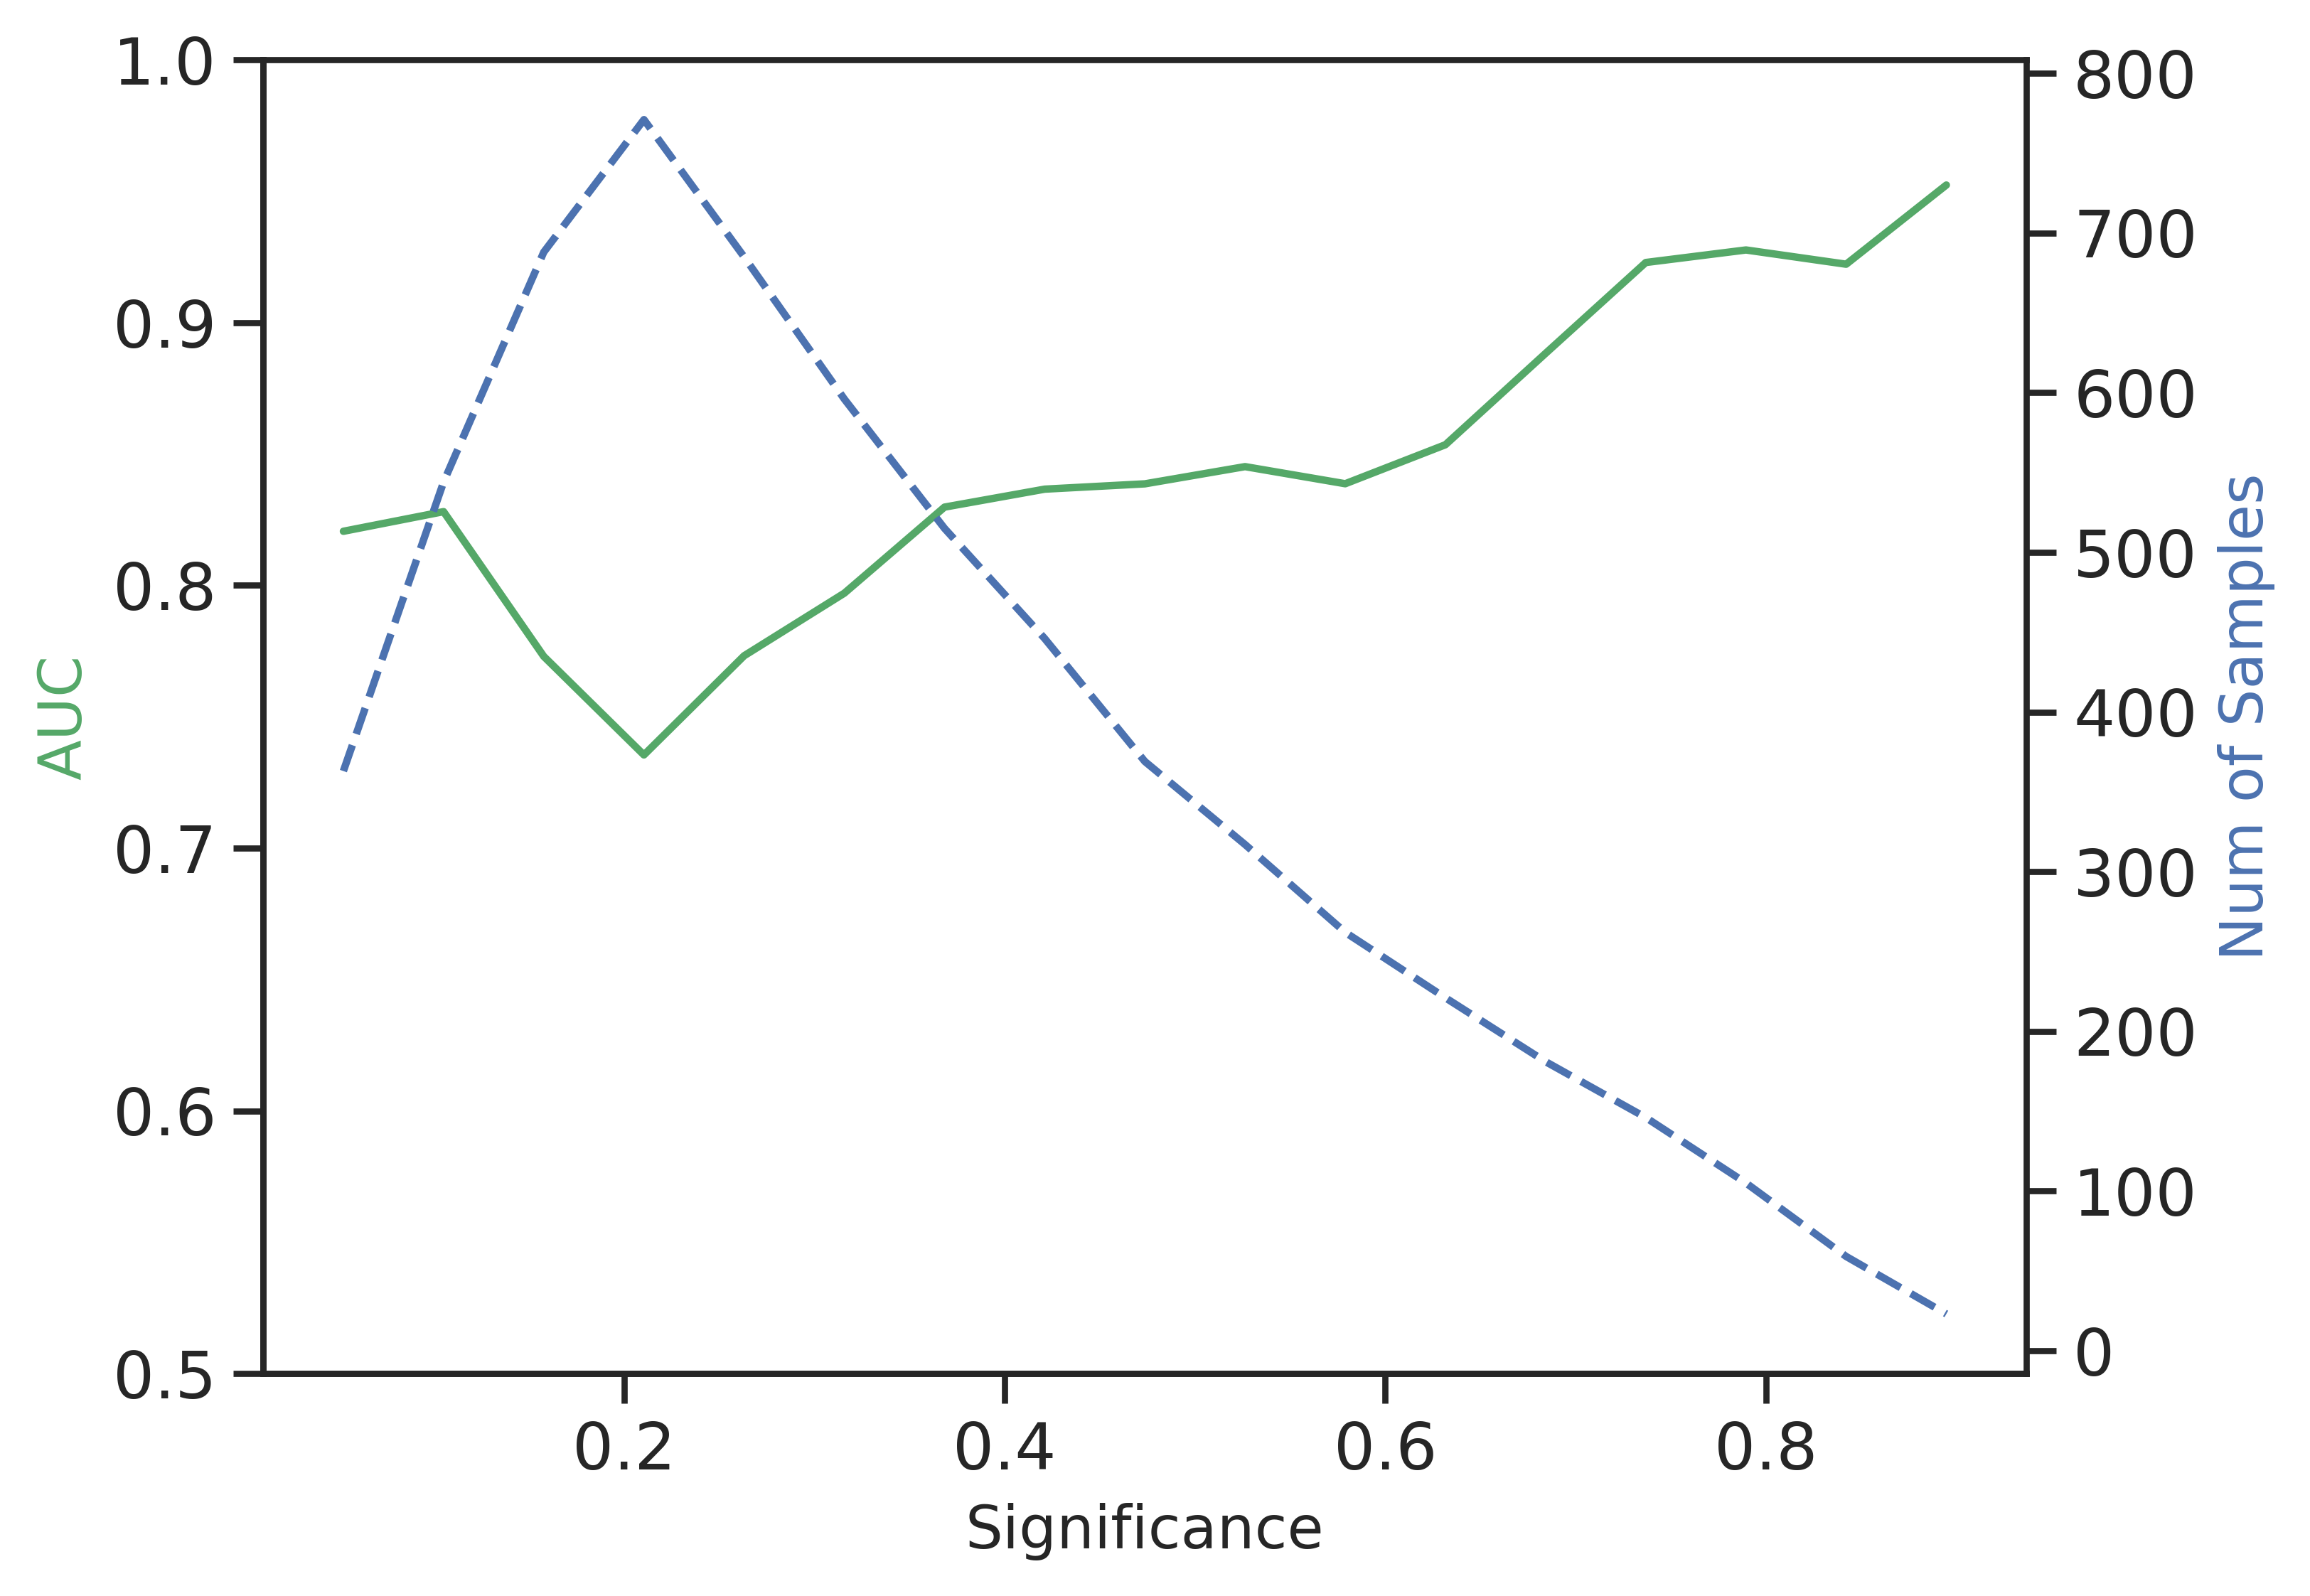

In [112]:
x = output_week4['sig']
y1= output_week4['auc']
y2= output_week4['num_samples']
 
fig, ax1 = plt.subplots(dpi=500)
ax2 = ax1.twinx()           # 做镜像处理
ax1.plot(x,y1,'g-')
ax2.plot(x,y2,'b--')
 
ax1.set_xlabel('Significance')    #设置x轴标题
ax1.set_ylabel('AUC',color = 'g')   #设置Y1轴标题
ax2.set_ylabel('Num of Samples', color = 'b')   #设置Y2轴标题
ax1.set_ylim(0.5, 1)

ax1.spines['top'].set_visible(True)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['right'].set_visible(True)

In [9]:
# after_y_test_clf = []
# after_y_pred_clf = []
# for i, j in zip(y_test_clf, icp.predict(test_preds.copy(),significance=.2)):
#     if j[0]==j[1]:
#         pass
#     else:
#         after_y_pred_clf.append(np.where(j==True)[0][0])
#         after_y_test_clf.append(i)

# print(f"CP model:\nnum: {len(after_y_test_clf)}",
#       'auc', roc_auc_score(after_y_test_clf, after_y_pred_clf), 
#       'acc',accuracy_score(after_y_test_clf, after_y_pred_clf),
#       'precision', precision_score(after_y_test_clf, after_y_pred_clf),
#       'recall', recall_score(after_y_test_clf, after_y_pred_clf)
#       )

In [10]:
# test_error = pd.read_csv('/home/jovyan/my_code/uncertainty/output/1_hERG_test_pred.csv')

# pvalues = np.ones((len(test_error['hERG']),2))
# for i in range(len(test_error['hERG'])):
#     pvalues[i,0] = test_error['hERG'][i]
#     pvalues[i,1] = 1-test_error['hERG'][i]
# y_test_clf = np.array(test_y['hERG'])

# assert len(pvalues) == len(y_test_clf)

In [20]:
# print(
#     metrics.average_c(pvalues, 0.1),
#     metrics.average_c(pvalues, 0.2),
#     metrics.average_c(pvalues, 0.3),
#     )

# print(
#     metrics.frac_single_label_preds(y_test_clf,pvalues, 0.1),
#     metrics.frac_single_label_preds(y_test_clf,pvalues, 0.2),
#     metrics.frac_single_label_preds(y_test_clf,pvalues, 0.3),
#     )

In [70]:
# obs_fuzz = metrics.obs_fuzziness(y_test_clf,pvalues)
# print("Observed fuzziness: %.3f" % obs_fuzz)



In [21]:
# # Perhaps most important, the calibration plot:
# calib_fig = plot.plot_calibration_clf(y_test_clf, 
#                                             pvalues, 
#                                             title='Calibration plot',
#                                             labels=['Safe','hERG'],
#                                             figsize=None)

In [22]:
# # Here we can customize the lines by passing matplotlib kw-arguments 
# # These are passed on to the axes.plot(..) method
# line_args = {'alpha': 0.75, 'marker':"*", 'linestyle': '-.', 'linewidth':2.5}

# # Or if you prefer confidence vs accuracy:
# conf_vs_acc_fig = plot.plot_calibration_clf(y_test_clf, 
#                                             pvalues, 
#                                             title='Calibration plot confidence vs accuracy',
#                                             labels=['Safe','hERG'],
#                                             sign_vals=np.arange(0.0,.5,0.01),
#                                             cm = ['red','blue','green'],
#                                             plot_all_labels=True, # If false - only plot 'overall accuracy'
#                                             flip_x=True, # confidence instead of significance on x-axis
#                                             flip_y=True, # accuracy instead of error rate on y-axis
#                                             **line_args) # passed on to matplotlib 

In [23]:
# label_distr_fig = plot.plot_label_distribution(y_true=y_test_clf,
#                                                    p_values=pvalues,
#                                                    sign_vals=np.arange(0,1,0.01),
#                                                    mark_best=True,
#                                                    display_incorrect=True,
#                                                    figsize = fig_size)

In [24]:
# CM_norm = metrics.confusion_matrix(y_test_clf, 
#                                    pvalues, 
#                                    sign=0.05, 
#                                    labels=['hERG','Safe'], 
#                                    normalize_per_class=True)

# heatmap_normalized_fig = plot.plot_confusion_matrix_heatmap(CM_norm,
#                                                                 cmap=sns.color_palette("crest", as_cmap=True),
#                                                                 vmin=0, vmax=1)

# bubbles_normalized_plot = plot.plot_confusion_matrix_bubbles(CM_norm,
#                                                                  annotate=True)

